<a href="https://colab.research.google.com/github/bernarducs/code_chunks/blob/master/Projeto_S%C3%A9ries_Temporais.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Detalhes do projeto

1 - Escolha uma ou duas bases de dados;

2 - Se necessário, faça um pré-processamento;
  - Analise as características da série temporal;
  - Utilize a Função de Auto-Correlação (FAC) e Função de Auto-Correlação Parcial (FACP)   

3 - Aplique um, ou dois métodos de previsão de série temporal:
  - Usar ARIMA, MLP e K-NN
  - Se escolher uma série temporal, utilize três métodos de previsão;
  - Se escolher duas série temporal, utilize dois métodos de previsão (ARIMA e MLP);

4 - Divida a série temporal em 50% treinamento, 25% validação e 25% teste para modelos de Machine Learning;
 - Divida a série temporal em 75% treinamento e 25% teste para o modelo ARIMA;

5 - Faça uma análise de sensibilidade dos parâmetros dos algoritmos utilizando o conjunto de validação (no caso das técnicas de Machine Learning);

6 - A partir da análise de sensibilidade, encontre os melhores parâmetros para cada método de previsão;

7 - Gere os resultados para o conjunto de teste;

8 - Compare os resultados a partir de duas, ou mais medidas de avaliação;
 - Sugestão: MSE, MAPE, POCID e MAE*

9 - Plote a previsão x série real

10 - Discuta qual o algoritmo que você escolheria para a base de dados analisada. 

OBS: Dividir o os dados em conjuntos de treinamento e teste, ou treinamento, validação e teste (se for necessário).

### Vehicle

Fonte: https://raw.githubusercontent.com/EraylsonGaldino/dataset_time_series/master/vehicle.txt

### Pacotes

In [311]:
# dados
import itertools
import numpy as np
import pandas as pd

In [312]:
# visualização
import matplotlib.pyplot as plt
import seaborn as sns;

In [313]:
# series temporais
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller  # teste de estacionariedade
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # autocorrelação (e (parcial)
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [314]:
# aprendizado de máquina (machine learning)
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.utils import check_array

### Funções de avaliação

Além do MSE importado acima, via scikit, utilizaremos também:

[SMAPE](https://en.wikipedia.org/wiki/Symmetric_mean_absolute_percentage_error)

In [315]:
def smape(real, predicao):
    denominador = (np.abs(real) + np.abs(predicao))
    diff = np.abs(real - predicao) / denominador
    diff[denominador == 0] = 0.0
    return 2.0 * np.mean(diff)

E armazenaremos os resultados no dicionário abaixo. Iremos retorná-lo na última seção (`Avaliação`) do notebook.

In [316]:
resultados = dict()

## Preparação

### Dataset

In [317]:
df = pd.read_csv('https://raw.githubusercontent.com/EraylsonGaldino/dataset_time_series/master/vehicle.txt', names=['freq'])
df.head(3)

,freq
0,4.367
1,5.147
2,5.418


Temos 252 linhas no dataset, a partir de 1971, mês a mês.

In [318]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252 entries, 0 to 251
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   freq    252 non-null    float64
dtypes: float64(1)
memory usage: 2.1 KB


In [319]:
df.index = pd.date_range(start='1/1/1971', freq="M", periods=len(df))

In [320]:
df.index.dtype

dtype('<M8[ns]')

In [321]:
df.head()

,freq
1971-01-31,4.367
1971-02-28,5.147
1971-03-31,5.418
1971-04-30,4.897
1971-05-31,5.002


### Características da Série

Plotando a série vemos que ela não é estacionária.

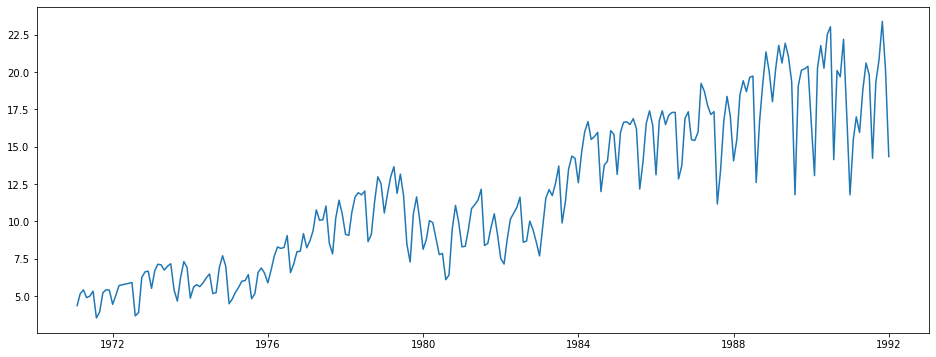

In [322]:
plt.figure(figsize=(16, 6))
plt.plot(df);

Dando 'zoom' nos úlitmos 24 períodos para observar a presença de ciclos.

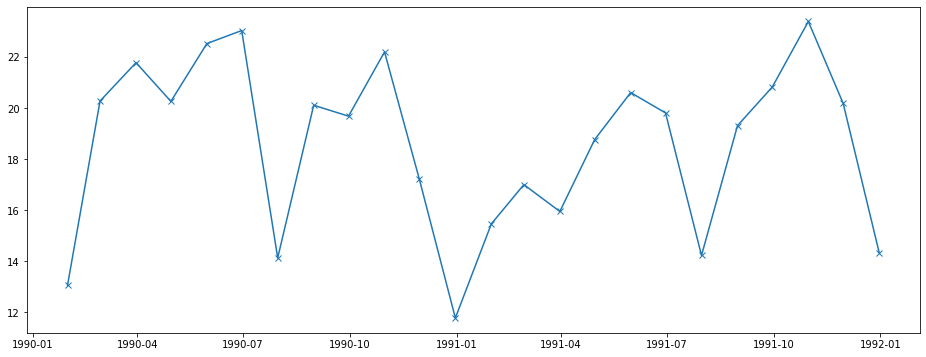

In [323]:
plt.figure(figsize=(16, 6))
plt.plot(df.tail(24), 'x-');

Usando *seasonal_decompose* do statsmodel fica mais clara a sazonalidade, com intervalo de 6 períodos.

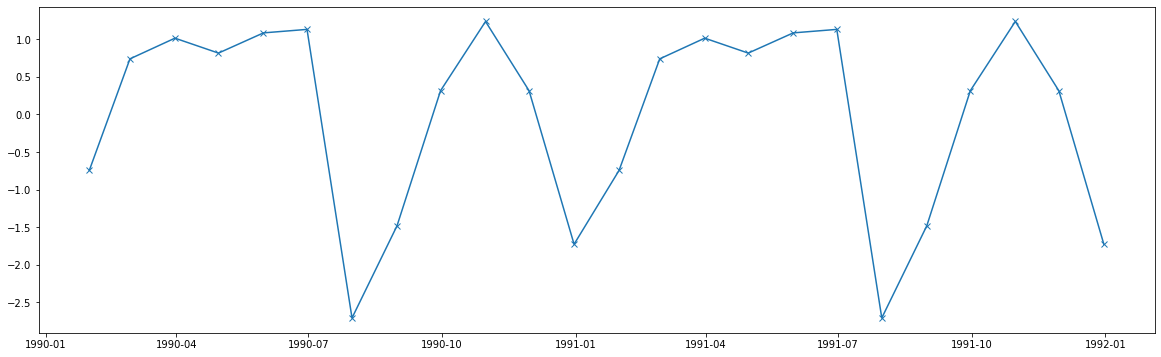

In [324]:
plt.figure(figsize=(20, 6))
decomp = seasonal_decompose(df)
plt.plot(decomp.seasonal[-24:], 'x-');

Plotando todos os tipos de decomposição vemos também que a tendência e o ruído aumenta com o passar do tempo.

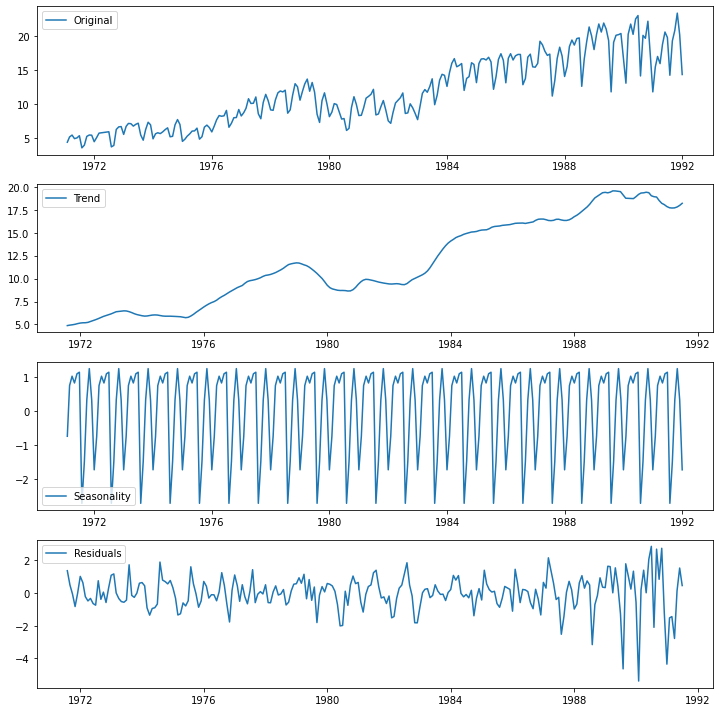

In [325]:
tendencia = decomp.trend
sazonalidade = decomp.seasonal
residuo = decomp.resid

plt.figure(figsize=(10, 10))
plt.subplot(411)
plt.plot(df, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(tendencia, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(sazonalidade,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residuo, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

### Treino e teste

In [326]:
n_dados_teste = int(len(df) * 0.25)
n_dados_teste

63

In [327]:
treino, teste = df[:-n_dados_teste], df[-n_dados_teste:]

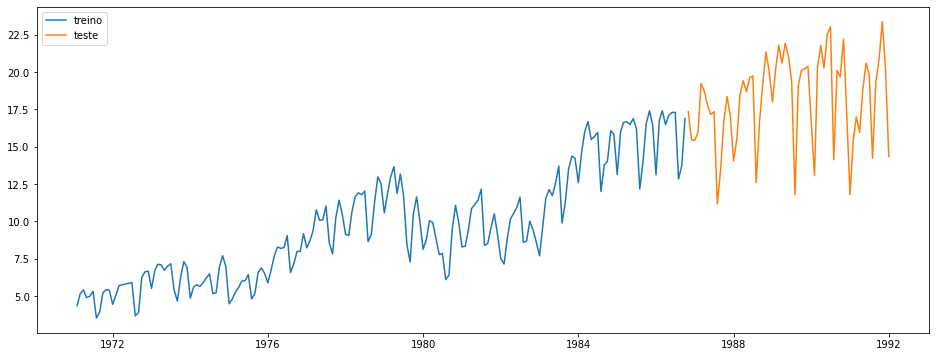

In [328]:
plt.figure(figsize=(16, 6))
plt.plot(treino, label='treino')
plt.plot(teste, label = 'teste')
plt.legend(loc= 'best');

## ARIMA e SARIMAX

### Série estacionária

Já com os dados de treino vamos diferenciar nossa série em 6 períodos como identificamos logo acima.

In [329]:
treino['6diff'] = treino.diff(6)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [330]:
def teste_df(serie, valor_critico=10):
    #H0: série não estacionária 
    dftest = adfuller(serie, autolag='AIC')
    df_output = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags','Nº Observações'])
    for key, value in dftest[4].items():
        df_output['Valor Crítico (%s)'%key] = value
    print(df_output)
    if df_output[0] < df_output[f"Valor Crítico ({valor_critico}%)"]: # descarta a H0 se o teste estatistico for menor que o valor crítico 
        
        print('--------estacionária')
    else:
        print(df_output[0])
        print('--------não estacionária')

Nossa diferenciação nos retornou estacionariedade com valor crítico de 5%.

In [331]:
teste_df(treino['6diff'].dropna(), 5)

Test Statistic          -2.989021
p-value                  0.035932
#Lags                    6.000000
Nº Observações         176.000000
Valor Crítico (1%)      -3.468062
Valor Crítico (5%)      -2.878106
Valor Crítico (10%)     -2.575602
dtype: float64
--------estacionária


Mas não para 1%

In [332]:
teste_df(treino['6diff'].dropna(), 1)

Test Statistic          -2.989021
p-value                  0.035932
#Lags                    6.000000
Nº Observações         176.000000
Valor Crítico (1%)      -3.468062
Valor Crítico (5%)      -2.878106
Valor Crítico (10%)     -2.575602
dtype: float64
-2.98902121143043
--------não estacionária


### Encontrando parâmetros para ARIMA

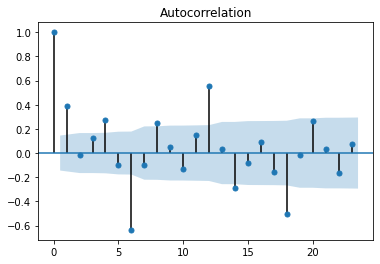

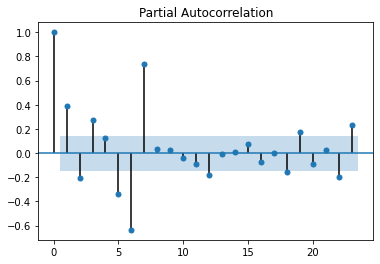

In [333]:
plot_acf(treino['6diff'].dropna());
plot_pacf(treino['6diff'].dropna());

A parti dos 2 gráficos acima temos os nos AR = 1 e MA = 3

In [334]:
arima_params = (3, 1, 1)

In [335]:
model_arima = ARIMA(treino['freq'].values, order=arima_params).fit()

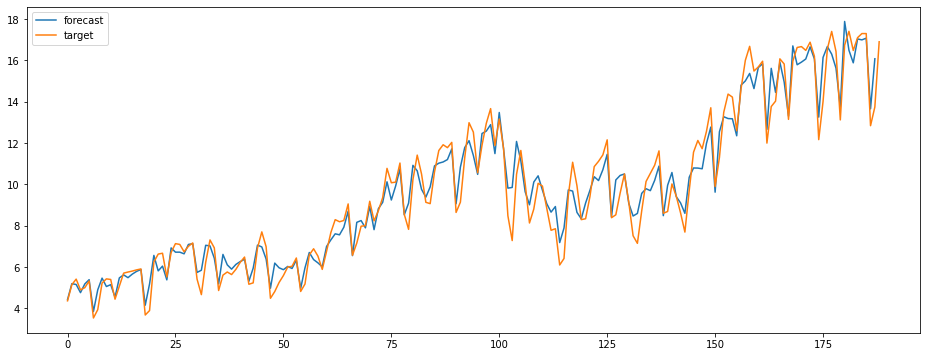

In [336]:
plt.figure(figsize=(16, 6))
plt.plot(model_arima.predict(typ='levels'), label = 'forecast')
plt.plot(treino.freq.values, label = 'target')
plt.legend()
plt.show()

### Testando o modelo

Como o Arima captura as relações lineares em seu modelo, observamos abaixo o resultado parecido com uma linha de tendência...

In [337]:
predito_arima = model_arima.predict(start=190, end=252, typ='levels')

In [338]:
previsao_arima = model_arima.forecast(len(teste))

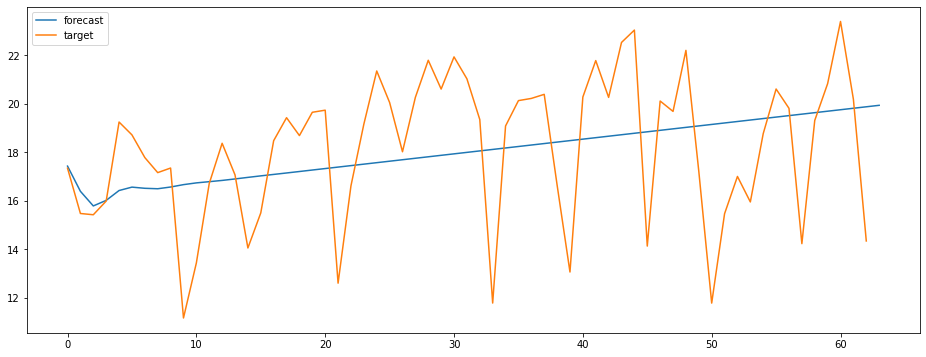

In [339]:
plt.figure(figsize=(16, 6))
plt.plot(predito_arima, label = 'forecast')
plt.plot(teste.freq.values, label = 'target')
plt.legend()
plt.show()

...já com SARIMAX (para realizar SARIMA, já que não estamos complementando com uma série exógena) temos a captação de boa parte dos ciclos característicos da série.

*Observação: segundo um dos manutendores do statmodels ARIMA se tornou ["maintenance-only"](https://github.com/statsmodels/statsmodels/issues/6225). SARIMAX é o pacote em que a comunidade traz melhorias contínuas.*

In [340]:
sarima_params = (*arima_params, 6)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:981: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


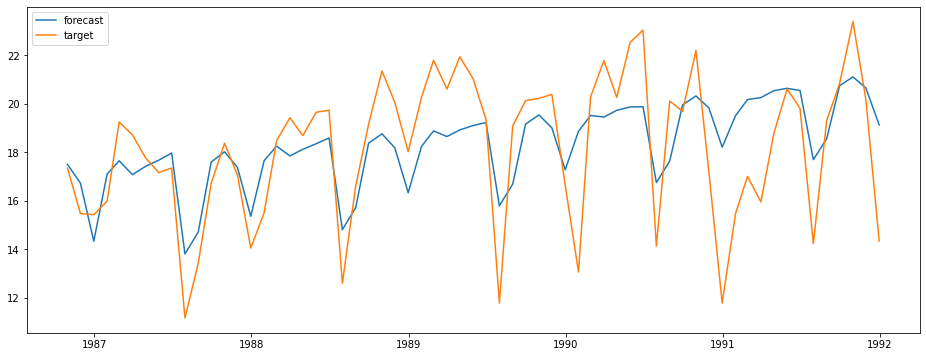

In [341]:
sarimax = SARIMAX(
    endog=treino['freq'], order=arima_params, seasonal_order=(sarima_params))

model_sarimax = sarimax.fit()

previsao_sarima = model_sarimax.forecast(len(teste))

plt.figure(figsize=(16, 6))
plt.plot(previsao_sarima, label = 'forecast')
plt.plot(teste.freq, label = 'target')
plt.legend()
plt.show()

In [342]:
mse(teste.freq.values, previsao_sarima)

5.026358757238922

In [343]:
model_sarimax.aic

447.4972530349206

Acima vimos *warnings* sobre o execução do modelo devido aos [parâmentros iniciais](https://groups.google.com/forum/#!topic/pystatsmodels/S_Fo53F25Rk) que possa ter resultado no resultado. 

Abaixo vamos fazer com que o SARIMAX defina enforce_stationarity/enforce_invertibility como `False` - afinal, já estamos passando parâmentros de diferenciação - e comparar seu desempenho com o MSE e AIC (The Akaike Information Critera), onde o valor mais baixo seria o [melhor](https://coolstatsblog.com/2013/08/14/using-aic-to-test-arima-models-2/).

In [344]:
sarimax = SARIMAX(
    endog=treino['freq'], order=arima_params, seasonal_order=(sarima_params), 
    enforce_stationarity=False, enforce_invertibility=False)

model_sarimax = sarimax.fit()

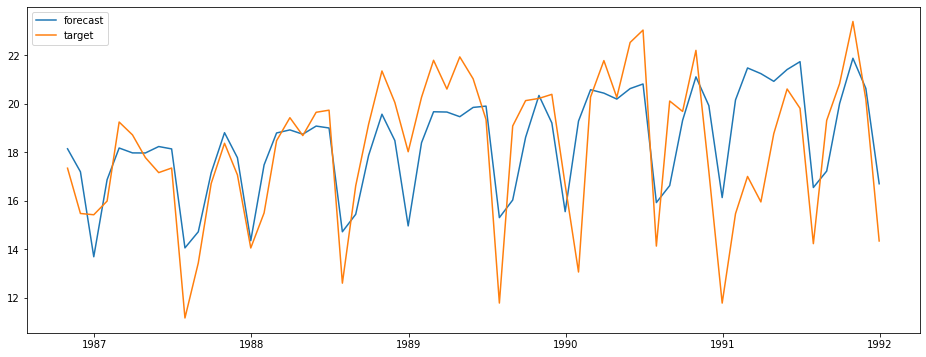

In [345]:
previsao_sarima = model_sarimax.forecast(len(teste))

plt.figure(figsize=(16, 6))
plt.plot(previsao_sarima, label = 'forecast')
plt.plot(teste.freq, label = 'target')
plt.legend()
plt.show()

In [346]:
mse(teste.freq.values, previsao_sarima)

4.477572223832219

In [347]:
model_sarimax.aic

406.2894851310492

In [348]:
smape(teste.freq.values, previsao_sarima)

0.09532914789167746

In [349]:
resultados['sarimax'] = {
    'mse': MSE(teste.freq.values, previsao_sarima),
    'smape': smape(teste.freq.values, previsao_sarima),
    'mae': mae(teste.freq.values, previsao_sarima)
                }

## Multlayer Perceptron (MLP)

No modelo arima fizemos a análise de autocorrelação e parcial-autocorrelação depois que a tornamos estacionária. Para MLP não há necessidade de passo prévio. Usamos autocorrelação aqui para estimar a quantidade de janelas de acordo com quantos lags estão em correlação com o registro de referência.

Abaixo temos uma janela para 18 lags.

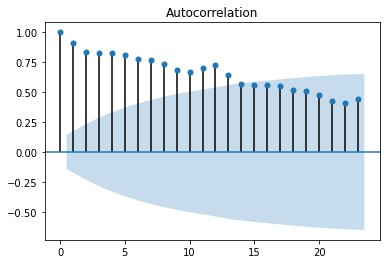

In [350]:
plot_acf(treino.freq);

### Janelas deslizantes (sliding windows)

In [351]:
def create_sliding_windows(series, window_size):
   
    list_of_sliding_windows = []
    list_size_to_iterate = len(series) - window_size 
    for i in range(0, list_size_to_iterate):
        window = series[i: i + window_size + 1]
        list_of_sliding_windows.append(window)

    return np.array(list_of_sliding_windows).reshape(len(list_of_sliding_windows), window_size + 1)

Dataset de treino com as janelas (acaba perdendo 18 linhas que é a quantidade de janelas, que serão  usadas no dataset de teste como `X_teste`).

In [352]:
windows_train = create_sliding_windows(treino.freq.values, 18)
windows_train.shape

(171, 19)

### Dados de validação

Na seção *Detalhes do projeto*, a divisão do dataset foi especificada para MPL foi de 50% treino, 25% validação e os 25% finais para teste. O dataset de validação vem como uma estimativa prévia do aprendizado do modelo.

Então vamos retirar 1/3 do de treino para corrigir as divisões e termos o dataset de validação.

In [353]:
perc_val = 0.33333
tam_val = np.fix(len(windows_train) *perc_val).astype(int)

X_train, y_train = windows_train[0:-tam_val, 0:-1], windows_train[0:-tam_val, -1]
X_val, y_val = windows_train[-tam_val:, 0:-1], windows_train[-tam_val:, -1]

In [354]:
print('X treino:', X_train.shape, '\t', 'y treino:', y_train.shape)
print('X validação:', X_val.shape, '\t', 'y validação:', y_val.shape)

X treino: (115, 18) 	 y treino: (115,)
X validação: (56, 18) 	 y validação: (56,)


Fazendo o mesmo para o dataset de teste mas com uma observação: vamos resgatar os 18 registros anteriores aos dados de teste a fim de obtermos dados das janelas para cada output do dataset de teste.

In [355]:
# resgatando os 18 pré aos dataset de teste
pontos_anteriores_test = teste.freq.values[-18:]
test = np.hstack([pontos_anteriores_test, teste.freq.values])

# gerando janelas e dividindo entre inputs e outputs
windows_test = create_sliding_windows(test, 18)
X_test, y_test = windows_test[:, 0:-1], windows_test[:, -1]

In [356]:
print('X teste:', X_test.shape, '\t', 'y teste:', y_test.shape)

X teste: (63, 18) 	 y teste: (63,)


Invertendo as ordens das matrizes na vertical. Assim o lag1, lag2 que estavam na extrema direita passam para índice 0, 1, 2... de cada linha do array

In [357]:
X_train_ajus = np.flip(X_train, 1)
X_val_ajus = np.flip(X_val, 1)
X_test_ajus = np.flip(X_test, 1)

### Modelo

Abaixo temos aplicação de grid search que nos dará o melhor modelo entre diversas combinações de parâmetros utilizadas pelo regressor MPL (`MPLRegressor`).

Treinamos varios conjuntos de neurônios, funcões de ativação, algoritmo de treinamento e taxa de aprendizado, criando um modelo com dados de teste por iteração (`mpl.fit`) e avaliando com os resultados de validação (`mpl.predict`), através do menos erro médio ao quadrado (`MSE`).

Executamos algumas vezes (`num_exec`) para minimizar resultados aleatórios.

In [358]:
def treinar_mlp(x_train, y_train, x_val, y_val, num_exec):
  neuronios = list(range(15, 25))
  func_activation = ['relu']#, 'logistic', 'tanh'] 
  alg_treinamento = ['lbfgs', 'sgd']#, 'adam']
  max_iteracoes = [10000]
  learning_rate = ['adaptive', 'invscaling']
  num_exec = list(range(0, num_exec))

  tup = (neuronios, func_activation, alg_treinamento, max_iteracoes, learning_rate, num_exec)

  best_result = np.Inf
  for i, j, l, m, n, e in itertools.product(*tup):

    mlp = MLPRegressor(
          hidden_layer_sizes=i, activation=j, solver=l, max_iter=m, learning_rate=n
          )
    mlp.fit(x_train, y_train)

    predict_validation = mlp.predict(x_val)  
    mse = MSE(y_val, predict_validation)
    if mse < best_result:
        best_result = mse
        select_model = mlp
  
  print('Modelo escolhido:\n', select_model, 'MSE:', best_result, '\n')
  return select_model

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Modelo escolhido:
 MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=17, learning_rate='adaptive',
             learning_rate_init=0.001, max_fun=15000, max_iter=10000,
             momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
             power_t=0.5, random_state=None, shuffle=True, solver='sgd',
             tol=0.0001, validation_fraction=0.1, verbose=False,
             warm_start=False) MSE: 0.769046828010666 



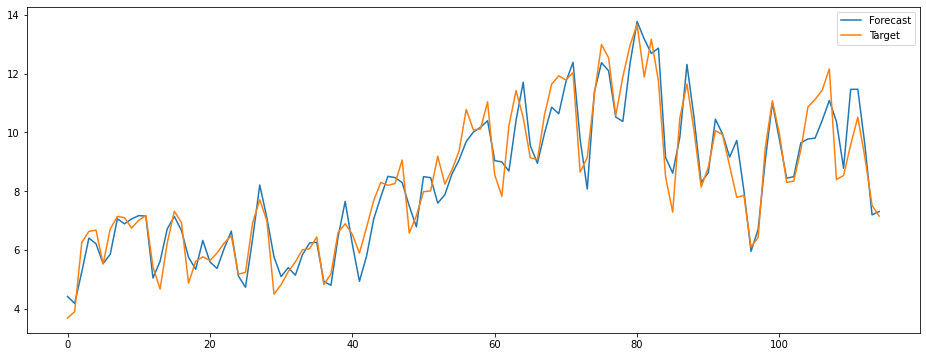

In [359]:
modelo =  treinar_mlp(X_train_ajus, y_train, X_val_ajus, y_val, 30)
trainPredict = modelo.predict(X_train_ajus)

plt.figure(figsize=(16, 6))
plt.plot(trainPredict, label='Forecast')
plt.plot(y_train, label='Target')
plt.legend()
plt.show()

### Testando o modelo

Com o melhor modelo selecionado usaremos nos dados de teste.

In [360]:
testPredict = modelo.predict(X_test_ajus)

In [361]:
mse(y_test, testPredict)

8.60603056493287

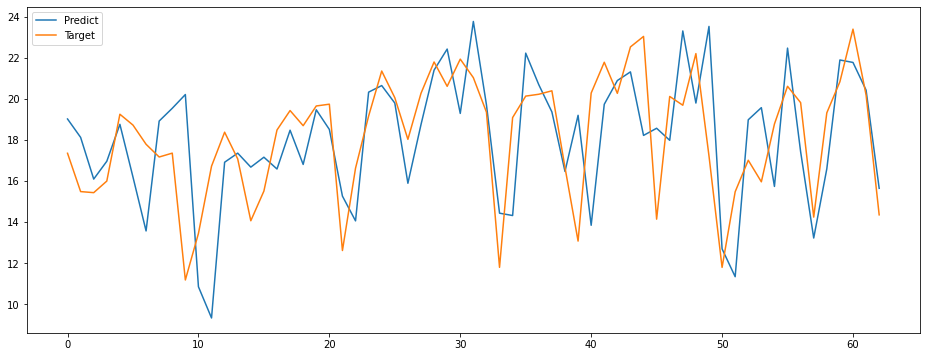

In [362]:
plt.figure(figsize=(16, 6))
plt.plot(testPredict, label = 'Predict')
plt.plot(y_test, label= 'Target')
plt.legend()
plt.show()

In [363]:
mse(y_test, testPredict)

8.60603056493287

### Com dataset normalizado

Normalizando a série na tentativa de aumentar a [estabilidade](https://machinelearningmastery.com/how-to-improve-neural-network-stability-and-modeling-performance-with-data-scaling/) de aprendizado do modelo. Uma ou mais features das 18 janelas podem [sobressair](https://towardsdatascience.com/everything-you-need-to-know-about-min-max-normalization-in-python-b79592732b79) mais que as demais, constribuindo de forma diferente para o modelo. Escalamos para que a série tem mín de 0 e máx de 1, sem alterar os seus desvios, portanto ela apresentará os mesmos 18 lags de autocorrelação.

In [364]:
X_train_scaled = MinMaxScaler().fit_transform(X_train_ajus)
y_train_scaled = np.ravel(MinMaxScaler().fit_transform(pd.DataFrame(y_train)))
X_val_scaled = MinMaxScaler().fit_transform(X_val_ajus)
y_val_scaled = np.ravel(MinMaxScaler().fit_transform(pd.DataFrame(y_val)))

X_test_scaled = MinMaxScaler().fit_transform(X_test_ajus)
scaler = MinMaxScaler().fit(pd.DataFrame(y_test))

In [365]:
y_test_scaled = np.ravel(scaler.transform(pd.DataFrame(y_test)))

Modelo escolhido:
 MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=24, learning_rate='adaptive',
             learning_rate_init=0.001, max_fun=15000, max_iter=10000,
             momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
             power_t=0.5, random_state=None, shuffle=True, solver='lbfgs',
             tol=0.0001, validation_fraction=0.1, verbose=False,
             warm_start=False) MSE: 0.0073097812655556265 



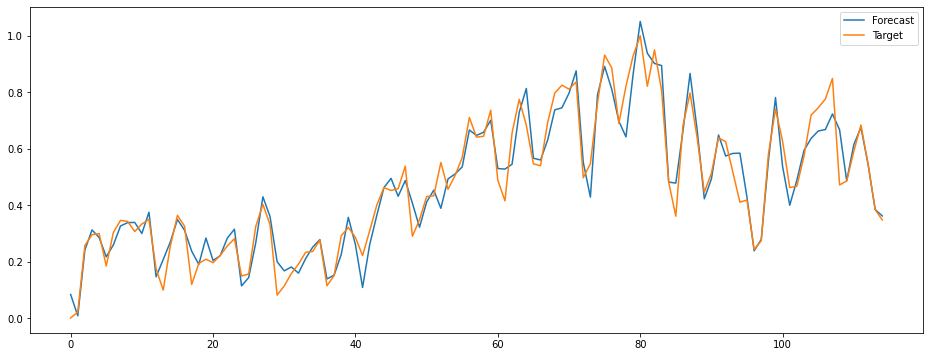

In [366]:
modelo =  treinar_mlp(X_train_scaled, y_train_scaled, X_val_scaled, y_val_scaled, 30)
trainPredict = modelo.predict(X_train_scaled)

plt.figure(figsize=(16, 6))
plt.plot(trainPredict, label='Forecast')
plt.plot(y_train_scaled, label='Target')
plt.legend()
plt.show()

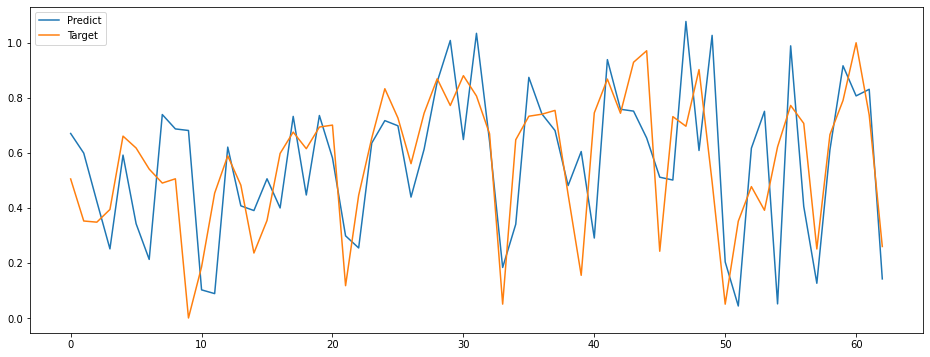

In [367]:
testPredict_scaled = modelo.predict(X_test_scaled)

plt.figure(figsize=(16, 6))
plt.plot(testPredict_scaled, label = 'Predict')
plt.plot(y_test_scaled, label= 'Target')
plt.legend()
plt.show()

In [368]:
mse(y_test_scaled, testPredict_scaled)

0.05666258348174654

In [369]:
smape(y_test, scaler.inverse_transform(testPredict_scaled.reshape(1, -1)))

0.13433751711536104

In [370]:
resultados['mlp'] = {
    'mse': MSE(y_test, scaler.inverse_transform(testPredict_scaled.reshape(-1, 1))),
    'smape': smape(y_test, scaler.inverse_transform(testPredict_scaled.reshape(1, -1))),
    'mae': mae(y_test, scaler.inverse_transform(testPredict_scaled.reshape(-1, 1)))
                }

## K-Nearest Neighbors (KNN)

Aqui cada conjunto de janelas é um vetor que possui um valor-alvo associado. Dado um novo vetor, KNN acha quais entre os vetores anteriores são os mais similares dentro do vetor - os vizinhos mais próximos (utilizando a distância euclidiana, por exemplo). [Como KNN é baseado em analogia](https://journal.r-project.org/archive/2019/RJ-2019-004/RJ-2019-004.pdf), ele prediz seu valor como uma agregação de valores alvos associados ao seus vizinhos.

In [371]:
def treinar_knn(x_train, y_train, x_val, y_val):
    
    k = [3, 6, 9, 18, 36]
    metric = ['euclidean', 'minkowski']
    leaf_size = [5, 15, 30, 45]
    
    hyper_param = list(itertools.product(k, metric, leaf_size))

    best_result = np.Inf
    for i, j, l in hyper_param:

      knn = KNeighborsRegressor(n_neighbors=i, metric=j, leaf_size=l, n_jobs=-1)
      knn.fit(x_train, y_train)
      predict_validation = knn.predict(x_val)
      mse = MSE(y_val, predict_validation)

      if mse < best_result:
          best_result = mse
          select_model = knn
    
    print('Modelo escolhido:\n', select_model, 'MSE:', best_result, '\n')
    return select_model

Modelo escolhido:
 KNeighborsRegressor(algorithm='auto', leaf_size=5, metric='euclidean',
                    metric_params=None, n_jobs=-1, n_neighbors=3, p=2,
                    weights='uniform') MSE: 0.022527650645425945 



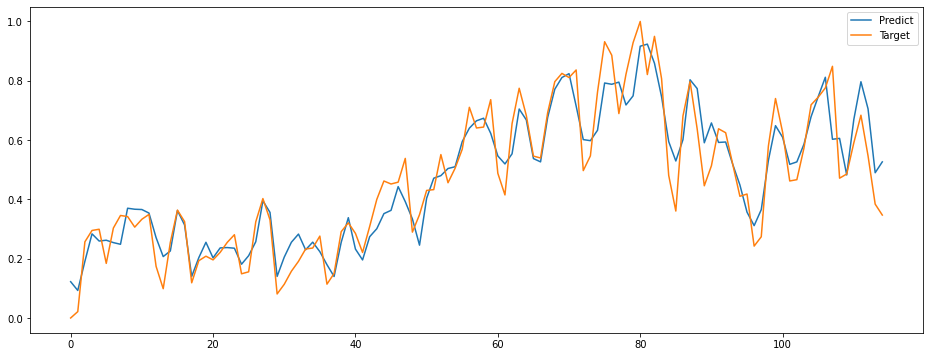

In [372]:
modelo =  treinar_knn(X_train_scaled, y_train_scaled, X_val_scaled, y_val_scaled)
trainPredict = modelo.predict(X_train_scaled)

plt.figure(figsize=(16, 6))
plt.plot(trainPredict, label='Predict')
plt.plot(y_train_scaled, label='Target')
plt.legend()
plt.show()

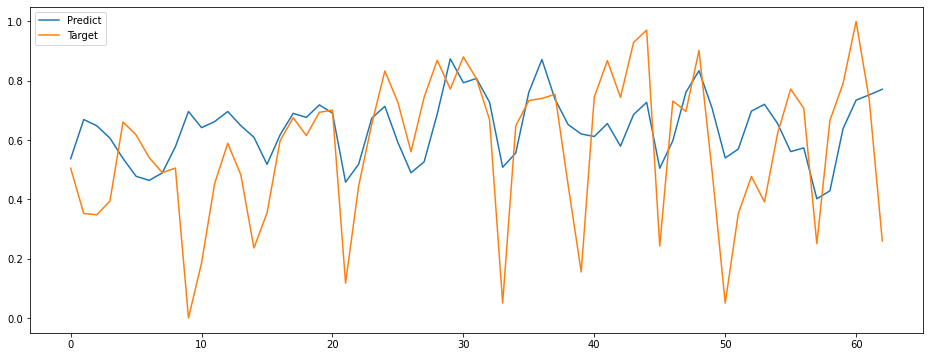

In [373]:
testPredict_knn = modelo.predict(X_test_scaled)

plt.figure(figsize=(16, 6))
plt.plot(testPredict_knn, label = 'Predict')
plt.plot(y_test_scaled, label= 'Target')
plt.legend()
plt.show()

In [374]:
mse(y_test_scaled, testPredict_knn)

0.05200777149497651

In [375]:
smape(y_test,
    scaler.inverse_transform(testPredict_knn.reshape(1, -1))
    )

0.12300329029137169

In [376]:
resultados['knn'] = {
    'mse': mse(y_test, scaler.inverse_transform(testPredict_knn.reshape(-1, 1))),
    'smape': smape(y_test, scaler.inverse_transform(testPredict_knn.reshape(1, -1))),
    'mae': mae(y_test, scaler.inverse_transform(testPredict_knn.reshape(-1, 1)))
       }

## Avaliação

In [381]:
pd.DataFrame.from_dict(resultados).T

,mse,smape,mae
sarimax,4.477572,0.095329,1.659227
mlp,8.457179,0.134338,2.330676
knn,7.762425,0.123003,2.149373


Utlizamos vehicle data como dataset para explorar 3 alternativas de time series forecasting - ARIMA, MLP e KNN. Vimos que o dataset possui sazonalidade de 6 intervalos, então usamos SARIMA que nos retornou melhores resultados. Melhor até que redes neurais usando Multilayer Perceptron e K-nearest neighbors. Este seria, portanto, nosso modelo escolhido para futuras previsões neste dataset.